# Detrend some variables on global grid

We do this in a separate notebook because it requires a few steps and quite a bit of resource.

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

import bottleneck

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "04:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41991 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/41991/status,
Dashboard: /proxy/41991/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.33:35053,Workers: 0
Dashboard: /proxy/41991/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr

In [6]:
%cd /g/data/w42/dr6273/work/demand_model//

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [7]:
era_path = "/g/data/w42/dr6273/work/data/era5/"

### First open the daily files, rechunk and store as zarr

I used 3 full nodes for this - takes a couple of minutes.

In [51]:
# Need to chunk when we open these files!
T = xr.open_mfdataset(era_path+"2t/daily/*.nc", chunks={"time": 500, "latitude": 500, "longitude": 300})

In [52]:
T.nbytes / 1024 ** 3

90.41259867325425

In [53]:
T = T.chunk({"time": -1, "latitude": 50, "longitude": 50})

In [55]:
T.to_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    mode="w",
    consolidated=True
)

### Now process one latitude at a time, and append to a zarr store

24 cores.

In [8]:
T = xr.open_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    consolidated=True,
    # chunks={"time": -1, "latitude": 1}
)

In [ ]:
%%time
for i in range(len(T["latitude"].values)):
    lat = T["latitude"].values[i]
    T_ = T.isel(latitude=i)
    
    # detrended = data - fit + mean
    Tmean = T_["t2m"].mean("time")
    Tfit = fn.detrend_dim(T_["t2m"], "time").astype("float32")
    Tdt = Tfit + Tmean
    
    Tdt = Tdt.to_dataset(name="t2m")
    Tdt = Tdt.expand_dims({"latitude": [lat]})
    Tdt = Tdt.chunk({"time": -1, "longitude": -1})
    
    if i == 0:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="w",
            consolidated=True
        )
    else:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="a",
            append_dim="latitude",
            consolidated=True
        )

In [10]:
test = xr.open_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            consolidated=True
        )

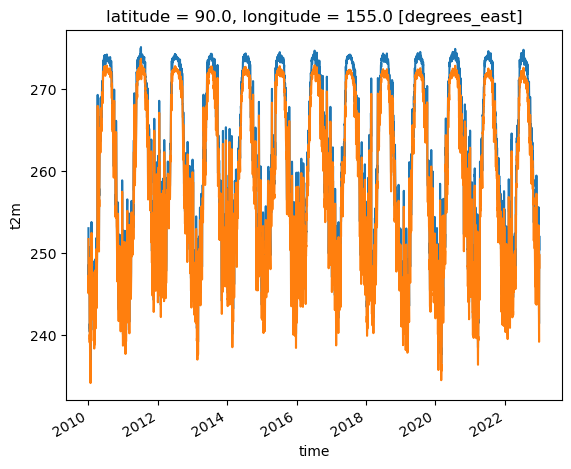

In [11]:
T.sel(latitude=90, longitude=155, time=slice("2010", "2022")).t2m.plot()
test.sel(latitude=90, longitude=155, time=slice("2010", "2022")).t2m.plot()